<a href="https://colab.research.google.com/github/yexf308/AppliedStatistics/blob/main/5_Ridge_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%pylab inline 
import pandas as pd
from scipy import linalg
from itertools import combinations
import scipy

Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$

# Ridge Regression
The polynomial regression with too high of a degree may have overfitting issue. One solution is to reduced the degree of the polynomial. However, a more general solution is to penalize the magnitude of the regression coefficients.

**Solution**: use MAP estimation with a zero-mean Gaussian prior on the weights, $p(\m{w})=\c{N}(\m{w}|\m{0},\lambda^{-1}\m{I}_D)$. This is **ridge regression** (Tikhonov regularization). Note $-\log(p(\m{w}))\propto \lambda \|\m{w}\|_2^2$

\begin{align}
\hat{\m w}_{\text{map}} = \arg\min_{\m{w}} \left(\|\mathbf{X}\mathbf{w}-\mathbf{y}\|_2^2+\lambda\|\m{w}\|_2^2\right)
\end{align}
where $\lambda>0$ is the penalty parameter. Denote the loss function $\ell(\m{w},\lambda) = \|\mathbf{X}\mathbf{w}-\mathbf{y}\|_2^2+\lambda\|\m{w}\|_2^2$. 

-  $\lambda=0$, reduce to least square. $\lambda=+\infty$,  $\m w=\m{0}$. The larger the value of $\lambda$, the more
the parameters are penalized for being large, and thus the less flexible the model. 

- The gradient is $\nabla\ell(\mathbf{w},\lambda)= 2(\mathbf{X}^\top\mathbf{X} \mathbf{w}-\mathbf{X}^\top\mathbf{y}+\lambda \mathbf{w}) $ (why?)

-  \begin{align}
\hat{\m{w}}_{\text{map}}&=(\m{X}^\top\m{X}+\lambda \m{I}_D)^{-1}\m{X}^\top \m{y}\\
&= (\sum_{i=1}^N \m{x}^{(i)}(\m{x}^{(i)})^\top +\lambda \m{I}_D)^{-1}\left(\sum_{i=1}^N y^{(i)}\m{x}^{(i)} \right) 
\end{align}
 Note $\m{X}^\top\m{X}+\lambda \m{I}_D$ is Positive definite. 

- The naive method is a bad idea. It can be slow and numerically unstable.  We can add “virtual data” to the training
set to get
 $\tilde{\m{X}}=\bcm \m{X} \\ \sqrt\Lambda \ecm$ and $\tilde{\m{y}}= \bcm \m{y} \\ \m{0}_{D\times 1} \ecm$, where $\sqrt{\Lambda}\in \mb{R}^{D\times D}$ is a diaginal matrix with $\sqrt{\lambda}$. 
In fact, $\hat{\m{w}}= (\tilde{\m{X}}^\top \tilde{\m{X}})^{-1}\tilde{\m{X}}^\top \tilde{\m{y}} $. 
Proof: 
\begin{align}
f(\m{w},\lambda)&= \left(\tilde{\m{y}} - \tilde{\m{X}} \m{w}\right)^\top\left(\tilde{\m{y}} - \tilde{\m{X}} \m{w}\right) \\
&=\left( \bcm \m{y}-\m{X}\m{w} \\ -\sqrt\Lambda \m{w} \ecm \right)^\top\left( \bcm \m{y}-\m{X}\m{w} \\ -\sqrt\Lambda \m{w}\ecm \right) \\
&= (\m{y}-\m{X}\m{w})^\top(\m{y}-\m{X}\m{w}) + \m{w}^\top \Lambda\m{w} \\
&=(\m{y}-\m{X}\m{w})^\top(\m{y}-\m{X}\m{w}) + \lambda\m{w}^\top \m{w} = \ell(\m{w},\lambda)
\end{align}






In [10]:
def ridge_qr_solve(X, y, l):
    D         = X.shape[1]
    sq_l      = diag(ones(D)*sqrt(l)) 
    X_tilde   = np.vstack([X, sq_l]) 
    y_tilde   = append(y, zeros(D)) 
    return np.dot(np.linalg.pinv(X_tilde), y_tilde)

   # Q, R = np.linalg.qr(X_tilde)
   # Qy = np.dot(Q.T, y_tilde)
   # return scipy.linalg.solve_triangular(R, Qy)

min of RSS in lambda is 7.457198054505023
optimal lambda is  8151.515151515152


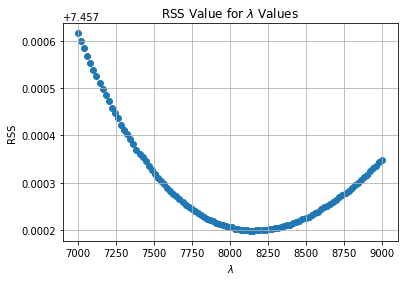

In [104]:
from sklearn.model_selection import train_test_split

# same data as before 
np.random.seed(0)
N = 35
x = np.linspace(0.0, 20, N)
X0 = x.reshape(N, 1)
w = np.array([-1.5, 1 / 9.0])
y = w[0] * x + w[1] * np.square(x)
y = y + np.random.normal(0, 1, N) * 2


# let's try  10th order polynomial 
d = 10
X        = np.ones((N, 1))
for i in range(1,d+1):
  X   = np.hstack([X, X0**i])

# use hold-out
# we split the data into two parts: training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#l_span   = [10**-3, 10**-2, 10**-1, 1, 10, 100, 1000, 10000]
l_span    = linspace(7000,9000,100)
RSS_test = []
w_store  = []
for l in l_span:
  w_hat     = ridge_qr_solve(X_train, y_train, l)
  yhat_test = X_test.dot(w_hat)
  w_store.append(w_hat)
  RSS_test.append(norm(y_test-yhat_test))


fig, ax = plt.subplots()
ax.scatter(l_span, RSS_test)
ylabel('RSS')
xlabel('$\lambda$')
title('RSS Value for $\lambda$ Values')
grid()
print('min of RSS in lambda is', min(RSS_test))  
print('optimal lambda is ', l_span[argmin(RSS_test)])


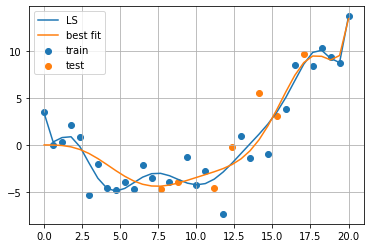

In [93]:
fig, ax = plt.subplots()
ax.scatter(X_train[:,1], y_train)
ax.scatter(X_test[:,1], y_test)

w_hat       = ridge_qr_solve(X, y, 0)
ax.plot(x,X.dot(w_hat))
w_hat_l     = ridge_qr_solve(X, y, l_span[argmin(RSS_test)])
ax.plot(x,X.dot(w_hat_l))
ax.legend(['LS','best fit','train','test'])
grid()


## Optional: ridge in sklearn package
**Warning:** this is just for reference, you should not use it in HW. 


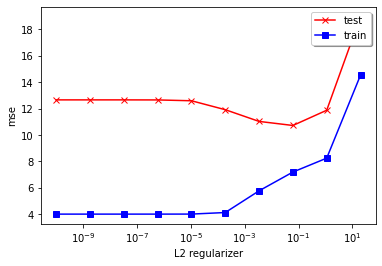

In [112]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse


xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

# Rescaling data
scaler = MinMaxScaler(feature_range=(-1, 1))
Xtrain = scaler.fit_transform(xtrain.reshape(-1, 1))
Xtest = scaler.transform(xtest.reshape(-1, 1))

deg = 10
l_span = np.logspace(-10, 1.3, 10)
L = len(l_span)
mse_train = np.empty(L)
mse_test = np.empty(L)
ytest_pred_stored = dict()
for i, l in enumerate(l_span):
    model = Ridge(alpha=l, fit_intercept=False)
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    Xtrain_poly = poly_features.fit_transform(Xtrain)
    model.fit(Xtrain_poly, ytrain)
    ytrain_pred = model.predict(Xtrain_poly)
    Xtest_poly = poly_features.transform(Xtest)
    ytest_pred = model.predict(Xtest_poly)
    mse_train[i] = mse(ytrain_pred, ytrain)
    mse_test[i] = mse(ytest_pred, ytest)
    ytest_pred_stored[l] = ytest_pred

# Plot MSE vs degree
fig, ax = plt.subplots()
mask = [True] * L
ax.plot(l_span[mask], mse_test[mask], color="r", marker="x", label="test")
ax.plot(l_span[mask], mse_train[mask], color="b", marker="s", label="train")
ax.set_xscale("log")
ax.legend(loc="upper right", shadow=True)
plt.xlabel("L2 regularizer")
plt.ylabel("mse")
plt.show()


## Cross-validation
How to choose the parameter $\lambda$? We can use the **hold-out** like before. 
However, if the size of the training set
is small, leaving aside 20\% for a validation set can result in an unreliable estimate of the model
parameters.

Another simple solution is **cross-validation (CV)**. 
- Split the training data into $K$-folds. 

- For each fold $k\in \{1, \dots, K\}$, we train on all the folds but the $k$th, and test on the $k$th, in a round-robin fashin. 

- The ERM is defined as 
\begin{align}
R_\lambda^{\text{CV}}= \frac{1}{K}\sum_{k=1}^K R_\lambda(\hat{\mm{\theta}}_\lambda(\c{D}_{-k}), \c{D}_k)
\end{align}
where $\c{D}_k$ is the data in the $k$th fold and $\c{D}_{-k}$ is all other data. 


If $K=N$, this method is called **leave-one-out cross validation**, since we train on $N-1$ iterms and test on the remaining one. 

<img src="https://github.com/yexf308/AppliedStatistics/blob/main/image/kfold.png?raw=true" width="400" />
